## Project Outline

### Import Data and Explain the Structure
1. Import data
2. Clean the data
3. Set up folder structure

### Label the Images
1. Reduce original labels to just the bounding box for list items
2. Reformat labels to work with YOLOv7

### Preprocess our images
1. Filter to gray scale
2. Binarize the image

### Train our model
1. Train the model
2. Predict on train and val set
3. Post-process predictions
4. Evaluate on train and val sets

### Final Evaluation on Test Set


### Import Data and Explain the Structure

In [ ]:
import os
#from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import re
from tqdm import tqdm # progress bar
import sklearn
from skimage.io import imread, imshow, imsave
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_yen, try_all_threshold
import skimage.filters

#### Processing and Reading in the Data*
**DELETE THE FOLLOWING FILES BEFORE PROCEEDING:** \
'archive (2)/SROIE2019/train/img/X51006619503.jpg' \
'archive (2)/SROIE2019/train/box/X51006619503.txt' \
'archive (2)/SROIE2019/train/entities/X51006619503.txt' \

Create a folder called box_clean, box_new, and box_final in both the training and testing folders. 

In [ ]:
# define a bunch of file paths
# these may need to be modified base on your file names and structure
box_folder_train = 'archive (2)/SROIE2019/train/box/'
box_folder_test = 'archive (2)/SROIE2019/test/box/'

box_clean_folder_train = 'archive (2)/SROIE2019/train/box_clean/'
box_clean_folder_test = 'archive (2)/SROIE2019/test/box_clean/'

box_new_folder_train = 'archive (2)/SROIE2019/train/box_new/'
box_new_folder_test = 'archive (2)/SROIE2019/test/box_new/'

box_final_folder_train = 'archive (2)/SROIE2019/train/box_final/'
box_final_folder_test = 'archive (2)/SROIE2019/test/box_final/'

img_folder_train = 'archive (2)/SROIE2019/train/img/'
img_folder_test = 'archive (2)/SROIE2019/test/img/'

img_names_train = [re.sub(r'(.+)(\.txt)', r'\1', name) for name in os.listdir(box_final_folder_train)] 
img_names_test = [re.sub(r'(.+)(\.txt)', r'\1', name) for name in os.listdir(box_final_folder_test)]

if img_names_train[0] == '.ipynb_checkpoints':
    img_names_train.remove('.ipynb_checkpoints')
if img_names_test[0] == '.ipynb_checkpoints':
    img_names_test.remove('.ipynb_checkpoints')
#print(img_names_train[0])
#print(img_names_test[0])

#### What our data looks like

In [ ]:
# Sample file out of the dataset

# two file paths to the TRAINING images and the labels

img_folder = 'archive (2)/SROIE2019/train/img/'
box_folder = 'archive (2)/SROIE2019/train/box/'
box_clean_folder = 'archive (2)/SROIE2019/train/box_clean/'

# get the individual file names
img_names = [re.sub(r'(.+)(\.jpg)', r'\1', name) for name in os.listdir('archive (2)/SROIE2019/train/img/')] 
#re.sub() is to truncate before the file extension

#.jpg for images, .txt for boxes

# print the first ten file names
print("First Ten Receipt Names. Add '.txt' when pulling labels, and '.jpg' when pulling images:")
print(img_names[:10],'\n')


img = cv2.imread(img_folder + img_names[4] + '.jpg')

print('First image, shape and plot. Note the axes.')
print('Shape:', img.shape)

plt.imshow(img);

### Clean the Data

#### Example Receipt for Data Cleaning

In [ ]:
# since the data sometimes has a ',' in the last column, we need to clean it 
# by surrounding the last column in quotes

# here is that process with the first receipt labels for illustration purposes
i = 0

orig_filename = box_folder + img_names[i] + '.txt'
new_filename = box_clean_folder + img_names[i] + '.txt'

with open(orig_filename, 'r') as file :
      filedata = file.read()

print('Original Labels:')
print(filedata[0:90]+'\n')

# Replace the target string

string_to_find = r'(\d+,\d+,\d+,\d+,\d+,\d+,\d+,\d+,)(.+)'

filedata = re.sub(string_to_find, r'\1\\\2\\', filedata)

print('Cleaned Labels:')
print(filedata[0:94])

# Write the file out again
with open(new_filename, 'w') as file:
      file.write(filedata)

#### Function for Cleaning

In [ ]:
# here a function to apply that process to all of the data
def clean_receipt_labels(img_names, 
                         box_folder, 
                         box_clean_folder):
    
    for img_name in img_names:
        # ignore checkpoints
        if (img_name != '.ipynb_checkpoints'):
            
            orig_filename = box_folder + img_name + '.txt'
            new_filename = box_clean_folder + img_name + '.txt'

            with open(orig_filename, 'r') as file :
                  filedata = file.read()

            # Replace the target string
            string_to_find = r'(\d+,\d+,\d+,\d+,\d+,\d+,\d+,\d+,)(.+)'

            filedata = re.sub(string_to_find, r'\1\\\2\\', filedata)

            # Write the file out again
            with open(new_filename, 'w') as file:
                  file.write(filedata)

#### Clean all Data

In [ ]:
# train
for i in tqdm(range(len(img_names_train))): # progress bar
    clean_receipt_labels(img_names_train, 
                         box_folder = box_folder_train,
                         box_clean_folder = box_clean_folder_train)

In [ ]:
# test
for i in tqdm(range(len(img_names_test))): # progress bar
    clean_receipt_labels(img_names_test, 
                         box_folder = box_folder_test,
                         box_clean_folder = box_clean_folder_test)

#### MANUALLY Copy all the 'clean' boxes (in box_clean) into the box_new folder before continuing!*
Once the labels are copied over, only modify the labels in **box_new**, so that box_clean is preserved

### Label the Images

#### Load in Original Labels

In [ ]:
#load in train labels
train_labels_dfs = []
for img_name in img_names_train:
    #print(img_name)
    img_boxes = pd.read_csv(box_clean_folder_train + img_name + '.txt', 
                            quotechar = '\\',
                           names = ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'content'])
    
    train_labels_dfs.append(img_boxes)
    #img_boxes.head()

In [ ]:
# load in test labels
test_labels_dfs = []
for img_name in img_names_test:
    #print(img_name)
    img_boxes = pd.read_csv(box_clean_folder_test + img_name + '.txt', 
                            quotechar = '\\',
                           names = ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'content'])
    
    test_labels_dfs.append(img_boxes)
    #img_boxes.head()

#### Functions to help labeling

In [ ]:
def show_image_with_all_boxes(img, img_name, img_boxes):
    for i in range(len(img_boxes)):
        x0 = img_boxes.loc[i]['x0']
        y0 = img_boxes.loc[i]['y0']

        x1 = img_boxes.loc[i]['x1']
        y1 = img_boxes.loc[i]['y1']

        x2 = img_boxes.loc[i]['x2']
        y2 = img_boxes.loc[i]['y2']

        x3 = img_boxes.loc[i]['x3']
        y3 = img_boxes.loc[i]['y3']

        cv2.line(img, (x0,y0), (x1,y1), (255,0,0), 2)
        cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.line(img, (x2,y2), (x3,y3), (255,0,0), 2)
        cv2.line(img, (x3,y3), (x0,y0), (255,0,0), 2)

        # Naming a window
    cv2.namedWindow("Receipt" + img_name, cv2.WINDOW_NORMAL)

    # Using resizeWindow()
    cv2.resizeWindow("Receipt" + img_name, 500, 700)
        
    cv2.imshow('Receipt' + img_name, img)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
# img.thumbnail((800,800), Image.LANCZOS)
# img
def get_bounding_box(df_boxes):
    
    x_min = df_boxes['x0'].min()
    x_max = df_boxes['x2'].max()
    y_min = df_boxes['y0'].min()
    y_max = df_boxes['y2'].max()

    x0_new = x_min
    y0_new = y_min
    x1_new = x_max
    y1_new = y_min
    x2_new = x_max
    y2_new = y_max
    x3_new = x_min
    y3_new = y_max
    
    return [x0_new, y0_new,
            x1_new, y1_new,
            x2_new, y2_new,
            x3_new, y3_new]

def show_image_with_bbox(img, img_name, bbox):
    cv2.line(img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,0,0), 5)
    cv2.line(img, (bbox[2],bbox[3]), (bbox[4],bbox[5]), (255,0,0), 5)
    cv2.line(img, (bbox[4],bbox[5]), (bbox[6],bbox[7]), (255,0,0), 5)
    cv2.line(img, (bbox[6],bbox[7]), (bbox[0],bbox[1]), (255,0,0), 5)

            # Naming a window
    cv2.namedWindow("Receipt" + img_name, cv2.WINDOW_NORMAL)

    # Using resizeWindow()
    cv2.resizeWindow("Receipt" + img_name, 500, 700)
        
    
    cv2.imshow('Receipt' + img_name, img)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

#### Labeling Instructions
Run the following three cells for each receipt that you are assigned to label.

1. The first cell shows you the original labels on the receipt.
    * Open the same file in the **box_new** folder and delete all the data that isn't a line item label
2. The second cell shows you the bounding box of the labels you chose to keep
    * Confirm that this label is correct
    * If it is not correct, make the necessary adjustments to the recipt label in **box_new**, the original receipt data is in **box_clean** if you need to restore the data
3. The third cell writes the final label to a new folder **box_final**
    * ONLY RUN THIS CELL IF THE LABEL IS CORRECT
    
Increment j, and repeat this process until all your receipts are labeled

##### Code for Training Labels

In [ ]:
# plot the boxes
# open the same label file in box_new
# delete everything but the line item labels


j = 1 # increment to change receipt


img_boxes = train_labels_dfs[j]
img_name = img_names_train[j]

img = cv2.imread(img_folder_train + img_name + '.jpg')

print(img_folder_train+img_name+'.jpg')

#show_image_with_all_boxes(img, img_name, img_boxes)

In [ ]:
# load in the new boxes
img_boxes_new = pd.read_csv(box_new_folder_train + img_name + '.txt', 
                            quotechar = '\\',
                           names = ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'content'])

# load in the clean image
img = cv2.imread(img_folder_train + img_name + '.jpg')

# get the bounding box
bbox = get_bounding_box(img_boxes_new)

print(bbox)

# plot the image with the bounding box to check work
show_image_with_bbox(img, img_name, bbox)

In [ ]:
# this cell finalizes the label and writes it to box_final

final_label = ','.join(str(b) for b in bbox)


final_filename = box_final_folder_train + img_name + '.txt'
# Write the file out again
with open(final_filename, 'w') as file:
      file.write(final_label)

##### Code for Testing Labels

In [ ]:
# plot the boxes
# open the same label file in box_new
# delete everything but the line item labels


j = 0 # increment to change receipt


img_boxes = test_labels_dfs[j]
img_name = img_names_test[j]

img = cv2.imread(img_folder_test + img_name + '.jpg')

show_image_with_all_boxes(img, img_name, img_boxes)

In [ ]:
# load in the new boxes
img_boxes_new = pd.read_csv(box_new_folder_test + img_name + '.txt', 
                            quotechar = '\\',
                           names = ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'content'])

# load in the clean image
img = cv2.imread(img_folder_test + img_name + '.jpg')

# get the bounding box
bbox = get_bounding_box(img_boxes_new)

#print(bbox)

# plot the image with the bounding box to check work
show_image_with_bbox(img, img_name, bbox)

In [ ]:
# this cell finalized the label and writes it to box_final

final_label = ','.join(str(b) for b in bbox)

final_filename = box_final_folder_test + img_name + '.txt'
# Write the file out again
with open(final_filename, 'w') as file:
      file.write(final_label)

#### Reformat Labels to work for YOLOv7
Re-format our labels to work for the YOLOv7 model and delete any corrupted images.

x0, y0, x1, y1, x2, y2, x3, y3 -> class_label  x_center  y_center  width  height

All yolo-formatted labels need to be nomalized my image size so that yolo can resize the image without distorting labels.

deleted:
* X51007231336 
* X51007231338
* X51007231344 - X51007231374 5 images
* X51009453804
* X51007231274 - X51007231372 8 images

In [ ]:
def format_label(image_name, image_folder, label_folder_read, label_folder_write):

    img = imread(image_folder + image_name + '.jpg')
    labels = pd.read_csv(label_folder_read + image_name + '.txt', names = ['x0', 'y0', 
                                                                                         'x1', 'y1',
                                                                                         'x2', 'y2', 
                                                                                         'x3', 'y3'])

    im_height, im_width, im_depth = img.shape

    width_x = labels.loc[0]['x1'] - labels.loc[0]['x0']
    height_y = labels.loc[0]['y2'] - labels.loc[0]['y1']

    center_x = width_x/2 + labels.loc[0]['x0']
    center_y = height_y/2 + labels.loc[0]['y1']

    rel_center_x = center_x/im_width
    rel_center_y = center_y/im_height

    rel_width = width_x/im_width
    rel_height = height_y/im_height
    
    label_components = ['0',rel_center_x, rel_center_y, rel_width, rel_height] # class, rel_center_x, rel_center_y, rel_width, rel_height

    final_label = ' '.join([str(x) for x in label_components])

    final_filename = label_folder_write + image_name + '.txt'
    # Write the file out again
    with open(final_filename, 'w') as file:
          file.write(final_label)

In [ ]:
box_yolo_folder_train = 'archive (2)/SROIE2019/train/box_yolo/'
box_yolo_folder_test = 'archive (2)/SROIE2019/test/box_yolo/'

In [ ]:
for img_name in img_names_train:
    #print(img_name)
    format_label(img_name, img_folder_train, box_final_folder_train, box_yolo_folder_train)
    
for img_name in img_names_test:
    #print(img_name)
    format_label(img_name, img_folder_test, box_final_folder_test, box_yolo_folder_test)

In [ ]:
print(f'Num Train Images: {len(img_names_train)}')
print(f'Num Test Images: {len(img_names_test)}')

### Preprocess our images
1. filtering to gray scale

In [ ]:
def binarize_img(image_name, image_folder_read, image_folder_write):
    receipt = imread(image_folder_read + image_name + '.jpg')
    
    norm_img = np.zeros((receipt.shape[0], receipt.shape[1]))
    receipt_norm = cv2.normalize(receipt, norm_img, 0, 255, cv2.NORM_MINMAX)
    
    gray_receipt = rgb2gray(receipt)
    #imshow(gray_receipt)
    thresh = threshold_yen(gray_receipt)
    binarized = gray_receipt > thresh
    
    final = img_as_ubyte(binarized)
    
    imsave(image_folder_write + image_name + '.jpg', final)
    #imshow(binarized)

In [ ]:
img_binary_folder_train = 'archive (2)/SROIE2019/train/img_binary/'
img_binary_folder_test = 'archive (2)/SROIE2019/test/img_binary/'

In [ ]:
for img_name in img_names_train:
    binarize_img(img_name, img_folder_train, img_binary_folder_train)
for img_name in img_names_test:
    binarize_img(img_name, img_folder_test, img_binary_folder_test)

In [ ]:
# select a subset (.42% of test or 15% of all data sample) to put into val
img_names_test_shuffled = sklearn.utils.shuffle(img_names_test)
img_names_val = img_names_test_shuffled[0:142]

In [ ]:
# move some of the test data to a valid set so that we have 65% train 15% valid 20% test

box_folder_val = 'archive (2)/SROIE2019/val/box/'
box_clean_folder_val = 'archive (2)/SROIE2019/val/box_clean/'
box_new_folder_val = 'archive (2)/SROIE2019/val/box_new/'
box_final_folder_val = 'archive (2)/SROIE2019/val/box_final/'
box_yolo_folder_val = 'archive (2)/SROIE2019/val/box_yolo/'
img_folder_val = 'archive (2)/SROIE2019/val/img/'
img_binary_folder_val = 'archive (2)/SROIE2019/val/img_binary/'

#i = 0
for image_name in img_names_val[1:]:
    #print(i, ': ', image_name)
    os.rename(box_folder_test + image_name + '.txt', box_folder_val +image_name + '.txt')
    os.rename(box_clean_folder_test + image_name + '.txt', box_clean_folder_val +image_name + '.txt')
    os.rename(box_new_folder_test + image_name + '.txt', box_new_folder_val +image_name + '.txt')
    os.rename(box_final_folder_test + image_name + '.txt', box_final_folder_val +image_name + '.txt')
    os.rename(box_yolo_folder_test + image_name + '.txt', box_yolo_folder_val +image_name + '.txt')
    os.rename(img_folder_test + image_name + '.jpg', img_folder_val +image_name + '.jpg')
    os.rename(img_binary_folder_test + image_name + '.jpg', img_binary_folder_val +image_name + '.jpg')
    #i = i+1


### Train our model
We will use Yolov7 to train on our data.\
[Yolo Tutorial 1](https://medium.com/mlearning-ai/object-detection-with-yolov7-a74fa1f03c7e) Main Tutorial I Followed\
[Yolo Tutorial 2](https://machinelearningprojects.net/train-yolov7-on-the-custom-dataset/)\
**Must run following cells on Colab with GPU**

Model results are stored in '/content/drive/Shareddrives/CS5841/yolov7/runs/train/yolov7-custom4'\

Evaluation results are stored in '/content/drive/Shareddrives/CS5841/yolov7/runs/detect'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install -r drive/Shareddrives/CS5841/yolov7/requirements.txt
#!pip install -r drive/Shareddrives/CS5841/yolov7/requirements_gpu.txt
%cd drive/Shareddrives/CS5841/yolov7/
!python train.py --workers 1 --device 0 --batch-size 8 --epochs 50 --img 640 320 --data data/receipt.yaml --cfg cfg/training/yolov7.yaml --name yolov7-custom --weights yolov7.pt

[Errno 2] No such file or directory: 'drive/Shareddrives/CS5841/yolov7/'
/content/drive/Shareddrives/CS5841/yolov7
2023-04-24 19:40:11.970177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 19:40:12.839847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7.pt', cfg='cfg/training/yolov7.yaml', data='data/receipt.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=50, batch_size=8, img_size=[640, 320], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync

In [ ]:
!python detect.py --weights runs/train/yolov7-custom4/weights/best.pt --conf 0.01 --name 'test' --save-txt --save-conf --img-size 640 --source ./test/images

Namespace(weights=['runs/train/yolov7-custom4/weights/best.pt'], source='./test/images', img_size=640, conf_thres=0.01, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=True, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='test', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2 line itemss

#### Post processing functions
One function reduces the predictions to just the prediction with the highest confidence. The other calculates the IOU for a prediction. 



In [ ]:

##create the folder to put post-processed labels in before running
def post_process_label(label_name, label_folder, post_processed_folder):
  '''post-processes a label to only include the highest confidence prediction

  args:
    label_name: the name of the label to post_process, should end in .txt
    label_folder: the folder with the original label
    post_processed_folder: the folder to store the post-processed label
  '''
  preds= pd.read_csv(prediction_folder + '/' + label_name, sep = ' ', names = ['class', 'x_center', 'y_center', 'width', 'height', 'conf'])

  best_pred = preds.loc[preds['conf'].idxmax()]

  final_label = ' '.join(str(x) for x in best_pred)

  final_filename = post_processed_folder + '/' + label_name

  with open(final_filename, 'w') as file:
        file.write(final_label)


# make sure to run this for all of our images, even ones that didnt have predictions made
def get_iou(label_name, pred_label_folder, true_label_folder):
  '''
  function to get the iou for a specific image

  args:
    label_name: the name of the label/image to get the iou, should end in .txt
    pred_label_folder: the folder with the predicted label
    true label folder: the folder with the true label
  '''
  true_label = pd.read_csv(true_label_folder + '/' + label_name, sep = ' ', names = ['class', 'x_center', 'y_center', 'width', 'height'])

  try:
      pred_label= pd.read_csv(pred_label_folder + '/' + label_name, sep = ' ', names = ['class', 'x_center', 'y_center', 'width', 'height', 'conf'])
      
  except FileNotFoundError:
      # if the file doesn't exist, a label was not predicted
      return 0

  pred_label['x_min'] = pred_label['x_center'] - pred_label['width']/2
  pred_label['x_max'] = pred_label['x_center'] + pred_label['width']/2
  pred_label['y_min'] = pred_label['y_center'] - pred_label['height']/2
  pred_label['y_max'] = pred_label['y_center'] + pred_label['height']/2

  true_label['x_min'] = true_label['x_center'] - true_label['width']/2
  true_label['x_max'] = true_label['x_center'] + true_label['width']/2
  true_label['y_min'] = true_label['y_center'] - true_label['height']/2
  true_label['y_max'] = true_label['y_center'] + true_label['height']/2

  #print(true_label['x_min'], true_label['x_max'], true_label['y_min'], true_label['y_max'])

  intersection_h = min(pred_label.loc[0]['y_max'], true_label.loc[0]['y_max']) - max(pred_label.loc[0]['y_min'], true_label.loc[0]['y_min'])
  intersection_w = min(pred_label.loc[0]['x_max'], true_label.loc[0]['x_max']) - max(pred_label.loc[0]['x_min'], true_label.loc[0]['x_min'])
  intersection_area = intersection_h *intersection_w

  if(intersection_h <0 or intersection_w < 0):
    # if the height or width of the intersection is negative, than there is no intersection
    return 0

  #print(intersection_h, intersection_w, intersection_area)

  union_h = max(pred_label.loc[0]['y_max'], true_label.loc[0]['y_max']) - min(pred_label.loc[0]['y_min'], true_label.loc[0]['y_min'])
  union_w = max(pred_label.loc[0]['x_max'], true_label.loc[0]['x_max']) - min(pred_label.loc[0]['x_min'], true_label.loc[0]['x_min'])
  union_area = union_h *union_w

  iou = intersection_area/union_area

  return iou



#### Post-process Labels and Get the IOUs for Test, Train, and Valid

In [ ]:
import numpy as np

In [ ]:
### this should really be made into a function, but I don't want to 

data_subset = 'val' # change to change the file paths 'train', 'val', or 'test

prediction_folder = '/content/drive/Shareddrives/CS5841/yolov7/runs/detect/' + data_subset + '/labels' # folder where the prediction labels are stored
labels = os.listdir(prediction_folder) # list of the names of the predicted labels

post_processed_folder = prediction_folder + '_post_processed' # folder where the prediction labels will be stored after post-processing 

## post process all the labels to keep prediction with highest confidence
for label_name in labels:
  post_process_label(label_name, prediction_folder, post_processed_folder)


true_label_folder = '/content/drive/Shareddrives/CS5841/yolov7/' + data_subset + '/labels' # folder wehre the ground truth labels are stored
true_names = os.listdir(true_label_folder) # list of the names of the ground truth labels


val_iou = [] # define a list to store ious

# get the iou for each label in the ground truth labels and store in the iou list
for label in true_names:
  #print(label)
  iou_temp = get_iou(label, post_processed_folder, true_label_folder)
  val_iou.append(iou_temp)


In [ ]:
#### THIS CELL JUST GETS IOU AND SKIPS POST_PROCESSING (assumes that it is already done)

data_subset = 'val'

prediction_folder = '/content/drive/Shareddrives/CS5841/yolov7/runs/detect/' + data_subset + '/labels' # folder where the prediction labels are stored
labels = os.listdir(prediction_folder) # list of the names of the predicted labels

true_label_folder = '/content/drive/Shareddrives/CS5841/yolov7/' + data_subset + '/labels' # folder wehre the ground truth labels are stored
true_names = os.listdir(true_label_folder) # list of the names of the ground truth labels

post_processed_folder = prediction_folder + '_post_processed' 

val_iou = [] # define a list to store ious, change to a unique variable

# get the iou for each label in the ground truth labels and store in the iou list
for label in true_names:
  #print(label)
  iou_temp = get_iou(label, post_processed_folder, true_label_folder)
  val_iou.append(iou_temp) # change here too

Mean Train IOU: 0.8592077365610519
Other stats:                 0
count  614.000000
mean     0.859208
std      0.229783
min      0.000000
25%      0.890913
50%      0.941516
75%      0.964662
max      0.996108

Mean Val IOU: 0.8227962043594717
Other stats:                 0
count  143.000000
mean     0.822796
std      0.238790
min      0.000000
25%      0.788493
50%      0.926766
75%      0.958341
max      0.990710


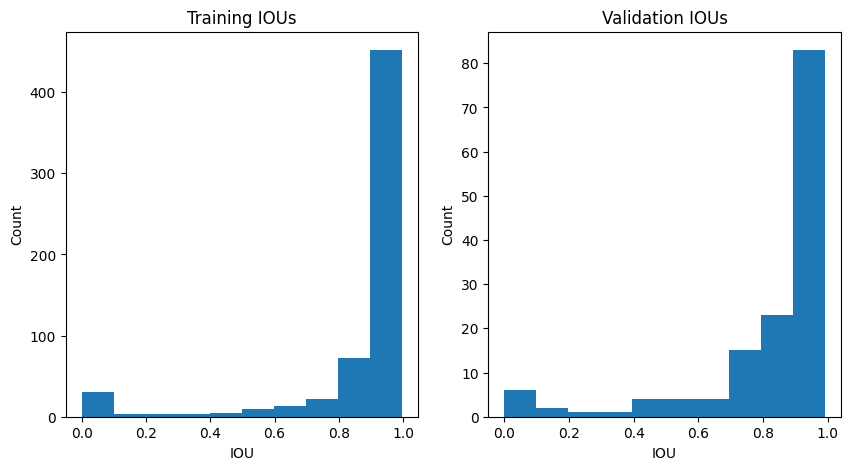

In [ ]:
f, ax = plt.subplots(1,2, figsize = (10, 5))

ax[0].hist(tr_iou, density = False);
ax[0].set_title('Training IOUs');
ax[0].set_ylabel('Count');
ax[0].set_xlabel('IOU');

ax[1].hist(val_iou, density = False);
ax[1].set_title('Validation IOUs');
ax[1].set_ylabel('Count');
ax[1].set_xlabel('IOU');

print(f'Mean Train IOU: {np.mean(tr_iou)}')
print(f'Other stats: {pd.DataFrame(tr_iou).describe()}\n')

print(f'Mean Val IOU: {np.mean(val_iou)}')
print(f'Other stats: {pd.DataFrame(val_iou).describe()}')

### Final Evaluation on Test Set

In [ ]:
data_subset = 'test'

prediction_folder = '/content/drive/Shareddrives/CS5841/yolov7/runs/detect/' + data_subset + '/labels'

labels = os.listdir(prediction_folder)

post_processed_folder = prediction_folder + '_post_processed'

## post process all the labels to keep prediction with highest confidence
for label_name in labels:
  post_process_label(label_name, prediction_folder, post_processed_folder)



true_label_folder = '/content/drive/Shareddrives/CS5841/yolov7/' + data_subset + '/labels'

te_iou = []

true_names = os.listdir(true_label_folder)

for label in true_names:
  #print(label)
  iou_temp = get_iou(label, post_processed_folder, true_label_folder)
  te_iou.append(iou_temp)

Mean Val IOU: 0.8416344378320462
Other stats:                 0
count  193.000000
mean     0.841634
std      0.233752
min      0.000000
25%      0.863136
50%      0.932095
75%      0.959772
max      0.998175


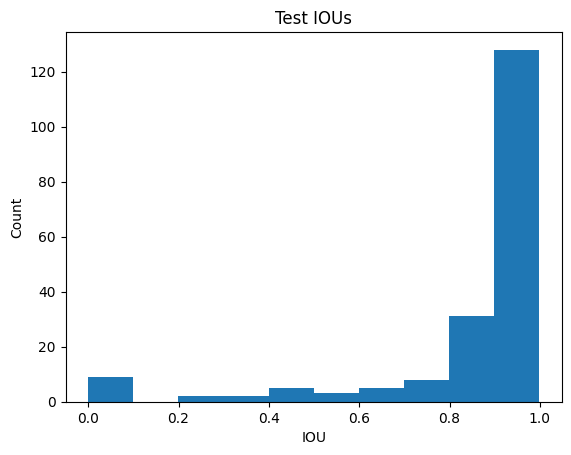

In [ ]:
plt.hist(te_iou, density = False);
plt.title('Test IOUs');
plt.ylabel('Count');
plt.xlabel('IOU');

print(f'Mean Val IOU: {np.mean(te_iou)}')
print(f'Other stats: {pd.DataFrame(te_iou).describe()}')
